In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, precision_recall_curve
import xgboost as xgb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [28]:
X = pd.read_csv('ufc-master-for-binary-classification_featured.csv', index_col='Unnamed: 0') #drop(columns=['RedFighter', 'BlueFighter', 'Result'], axis=1)
y = pd.read_csv('ufc-master-for-binary-classification.csv', index_col='Unnamed: 0')['Result']

In [13]:
X = pd.read_csv('user_data_mol_features_toxric.csv', index_col='Unnamed: 0')

In [14]:
X['LD50_log'] = (X['LD50_log'] > 8.52).astype(int)
y = X['LD50_log']
X = X.drop(columns=['LD50', 'LD50_log'], axis=1)
# Разбиваем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=8)

In [15]:
# Выбор столбцов по индексу
columns_to_check = X_train.columns[3:213]

# Заполнение пропусков медианой для всех числовых столбцов
X_train[columns_to_check] = X_train[columns_to_check].fillna(X_train[columns_to_check].median())
X_test[columns_to_check] = X_test[columns_to_check].fillna(X_train[columns_to_check].median())

# Проверка на наличие inf в указанных столбцах
inf_check = X_train[columns_to_check].apply(np.isinf)

# Получение имен столбцов с inf значениями
inf_columns = inf_check.any(axis=0)  # Проверяем по строкам для каждого столбца
inf_columns = inf_columns[inf_columns].index.tolist()  # Фильтруем только True значения

print(inf_columns)

X_train = X_train.drop(columns=inf_columns, axis=1)
X_test = X_test.drop(columns=inf_columns, axis=1)

['MaxPartialCharge', 'MaxAbsPartialCharge']


In [16]:
# Разделяем столбцы в зависимости от типа хранимых данных
cat_columns = X_train.columns[1:3].tolist()
numeric_columns = X_train.columns[3: 213].tolist()
binary_columns = X_train.columns[213: 2428]

# Кодируем категориальные признаки
encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, dtype='byte').set_output(transform='pandas')

X_train_cat_encoded = encoder.fit_transform(X_train[cat_columns])
X_test_cat_encoded = encoder.transform(X_test[cat_columns])

# Масштабируем числовые признаки
# scaler = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=8).set_output(transform='pandas')
scaler = MinMaxScaler().set_output(transform='pandas')

X_train_numeric_scaled = scaler.fit_transform(X_train[numeric_columns])
X_test_numeric_scaled = scaler.transform(X_test[numeric_columns])

# Объединяем обработанные столбцы в один датафрейм
X_train_preprocessed = pd.concat([X_train_cat_encoded, X_train_numeric_scaled, X_train[binary_columns]], axis=1)
X_test_preprocessed = pd.concat([X_test_cat_encoded, X_test_numeric_scaled, X_test[binary_columns]], axis=1)

In [17]:
# # Обучение модели
# xgb_model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=99, max_depth=6, learning_rate=0.1, n_estimators=100)
# xgb_model.fit(X_train_preprocessed, y_train)

# # Предсказание на тестовой выборке
# y_pred = xgb_model.predict(X_test_preprocessed)
# y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# # Расчет метрик
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred)
# roc_auc = roc_auc_score(y_test, y_pred_proba)

# # Расчет PR-AUC
# precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
# pr_auc = auc(recall_pr, precision_pr)

# Определение целевой функции для оптимизации
def objective(trial):
    # Определение гиперпараметров для перебора
    params = {
            'max_depth': trial.suggest_int('max_depth', 5, 40),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 50, 250),
            'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 10),
            'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100)
    }

    # Обучение модели
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', **params)
    xgb_model.fit(X_train_preprocessed, y_train)

    # Предсказание на тестовой выборке
    y_pred = xgb_model.predict(X_test_preprocessed)
    y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

    # Расчет метрики PR-AUC
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall_pr, precision_pr)

    return pr_auc

# Перебор гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

# Обучение лучшей модели
best_params = study.best_params
best_model = xgb.XGBClassifier(objective='binary:logistic', **best_params)
best_model.fit(X_train_preprocessed, y_train)

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test_preprocessed)
y_pred_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_pr, precision_pr)

# Вывод метрик
print('Лучшие гиперпараметры:', best_params)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')

[I 2025-01-15 10:42:22,823] A new study created in memory with name: no-name-3edc642c-1c84-496f-9ec4-93138fc73c58
[I 2025-01-15 10:42:33,099] Trial 0 finished with value: 0.6091091606212511 and parameters: {'max_depth': 19, 'learning_rate': 0.2565108335344441, 'n_estimators': 63, 'gamma': 0.018783216960126803, 'subsample': 0.6253045913328437, 'colsample_bytree': 0.969103482297682, 'reg_alpha': 0.28528230869246674, 'reg_lambda': 0.4541366742535945, 'scale_pos_weight': 69}. Best is trial 0 with value: 0.6091091606212511.
[I 2025-01-15 10:42:43,510] Trial 1 finished with value: 0.5831189819020764 and parameters: {'max_depth': 22, 'learning_rate': 0.3127800815684751, 'n_estimators': 69, 'gamma': 0.060307987390261227, 'subsample': 0.6682700832154089, 'colsample_bytree': 0.803990777752806, 'reg_alpha': 0.017308098734980598, 'reg_lambda': 0.14838732026981954, 'scale_pos_weight': 33}. Best is trial 0 with value: 0.6091091606212511.
[I 2025-01-15 10:42:57,665] Trial 2 finished with value: 0.532

Лучшие гиперпараметры: {'max_depth': 16, 'learning_rate': 0.15510836389386634, 'n_estimators': 239, 'gamma': 0.017885967426803675, 'subsample': 0.8412376637722473, 'colsample_bytree': 0.9516226165290792, 'reg_alpha': 0.05260877895896949, 'reg_lambda': 3.2575424366498074, 'scale_pos_weight': 97}
Precision: 0.7050
Recall: 0.5868
F1: 0.6405
ROC-AUC: 0.9241
PR-AUC: 0.6174


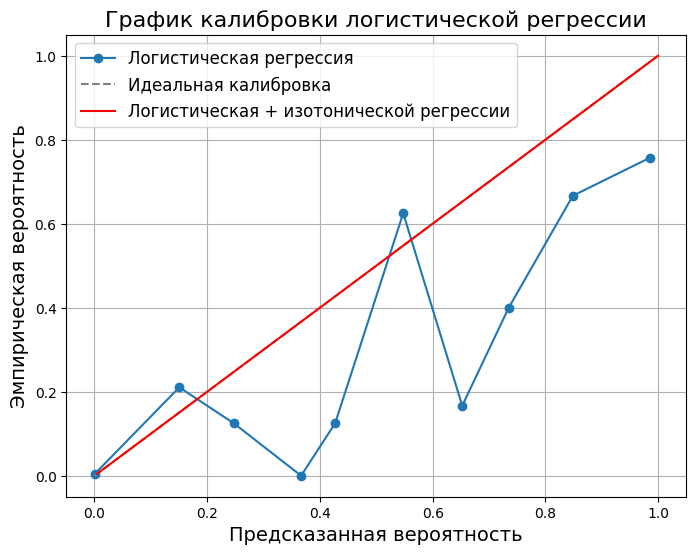

In [18]:
from sklearn.calibration import calibration_curve, FrozenEstimator, CalibratedClassifierCV


# Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')

# Каоибровка вероятностей
calibrated_model_iso = CalibratedClassifierCV(FrozenEstimator(best_model), method='isotonic', cv='prefit')
calibrated_model_iso.fit(X_test_preprocessed, y_test)

# Предсказанные вероятности после калибровки
calibrated_probs_iso = calibrated_model_iso.predict_proba(X_test_preprocessed)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs_iso, n_bins=10, strategy="uniform")
plt.plot(prob_pred, prob_true, color='red', label='Логистическая + изотонической регрессии')
plt.xlabel('Предсказанная вероятность', fontsize=14)
plt.ylabel('Эмпирическая вероятность', fontsize=14)
plt.title('График калибровки логистической регрессии', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

In [19]:
y_pred = calibrated_model_iso.predict(X_test_preprocessed)

precision_pr, recall_pr, _ = precision_recall_curve(y_test, calibrated_probs_iso )
pr_auc = auc(recall_pr, precision_pr)

log_reg_recall = recall_score(y_test, y_pred)
log_reg_precision = precision_score(y_test, y_pred)
log_reg_f1 = f1_score(y_test, y_pred)
log_reg_accuracy = accuracy_score(y_test, y_pred)
log_reg_roc_auc = roc_auc_score(y_test, calibrated_probs_iso)

log_reg_metrics = [(np.round(log_reg_recall, 3),
                    np.round(log_reg_precision, 3),
                    np.round(log_reg_f1, 3),
                    np.round(log_reg_accuracy, 3),
                    np.round(log_reg_roc_auc, 3),
                    np.round(pr_auc, 3))]

metrics = pd.DataFrame(data = log_reg_metrics, columns=['Recall','Precision','F1 Score', 'Accuracy', 'ROC-AUC', 'PR-AUC'])
metrics.insert(0, 'Model', 'LogReg+Isotonic Regression')
metrics

,Model,Recall,Precision,F1 Score,Accuracy,ROC-AUC,PR-AUC
0,LogReg+Isotonic Regression,0.443,0.871,0.587,0.993,0.93,0.64


In [20]:
# Инициализация пустого DataFrame
metrics = pd.DataFrame(columns=['Threshold', 'Recall', 'Precision', 'F1 Score'])

# fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16,16))
thresholds = np.arange(0.1, 1, 0.1)

for i in range(9):

    predictions = (calibrated_probs_iso  >= thresholds[i]).astype(int)
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, calibrated_probs_iso )
    pr_auc = auc(recall_pr, precision_pr)
    log_reg_recall = recall_score(y_test, predictions)
    log_reg_precision = precision_score(y_test, predictions)
    log_reg_f1 = f1_score(y_test, predictions)
    log_reg_accuracy = accuracy_score(y_test, predictions)
    log_reg_roc_auc = roc_auc_score(y_test, predictions)

   # Создание новой строки в виде DataFrame
    new_row = pd.DataFrame(data=[[thresholds[i],
                                np.round(log_reg_recall, 3),
                                np.round(log_reg_precision, 3),
                                np.round(log_reg_f1, 3)]],                              

                            columns=['Threshold', 'Recall', 'Precision', 'F1 Score']
                            )

    # Добавление строки с помощью pd.concat
    metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

,Threshold,Recall,Precision,F1 Score
0,0.1,0.629,0.593,0.610
1,0.2,0.605,0.664,0.633
2,0.3,0.587,0.705,0.641
3,0.4,0.539,0.763,0.632
4,0.5,0.485,0.818,0.609
5,0.6,0.443,0.871,0.587
6,0.7,0.395,0.917,0.552
7,0.8,0.395,0.917,0.552
8,0.9,0.216,1.000,0.355


In [48]:
X = pd.read_csv('X_2000_featured.csv', index_col='Unnamed: 0') #.loc[:1700, :]
y = pd.read_csv('y_2000.csv', index_col='Unnamed: 0') #.loc[:1700, :]

In [49]:
# X = X.iloc[:1900, :]
# y = y.iloc[:1900]


test_size = int(len(X)*0.1)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [55]:
y_train =np.array(y_train)
y_test =np.array(y_test)

In [212]:
# Масштабируйте данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Случайный лес

In [3]:
df = pd.read_csv('X_y_5500.csv', index_col='Unnamed: 0')
X = df.drop('Result', axis=1)
y = df['Result']

test_size = int(len(X)*0.1)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

In [5]:
scaler = MinMaxScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Модель случайного леса
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=folds, scoring='f1', verbose=True, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"Лучшие гиперпараметры для случайного леса: {grid_search_rf.best_params_}")
print(f"Лучший результат для случайного леса: {grid_search_rf.best_score_}")

# Используйте лучшую модель для предсказания
y_pred_rf_best = grid_search_rf.best_estimator_.predict(X_test_scaled)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Лучшие гиперпараметры для случайного леса: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Лучший результат для случайного леса: 0.4848622119625559


Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.67       287
           1       0.65      0.48      0.55       270

    accuracy                           0.62       557
   macro avg       0.63      0.62      0.61       557
weighted avg       0.63      0.62      0.61       557



Text(0.5, 23.52222222222222, 'predicted value')

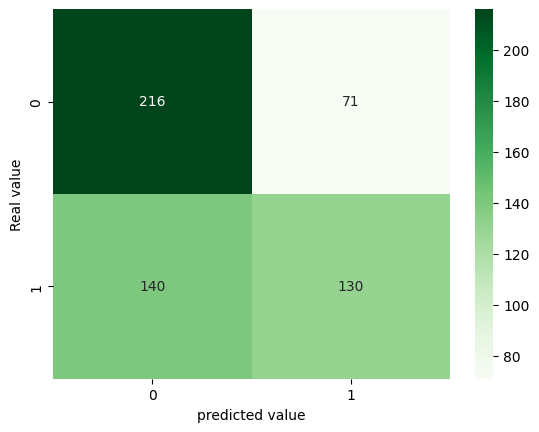

In [7]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_rf_best))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_rf_best),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [8]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 5, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Создание модели
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

    # Обучение модели
    rf.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = rf.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=50)

# Вывод лучших гиперпараметров и результата
print("Лучшие гиперпараметры:", study.best_params)
print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_rf = RandomForestClassifier(**study.best_params)
best_rf.fit(X_train_scaled, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_rf.predict(X_test_scaled)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred))

[I 2025-01-15 09:33:04,774] A new study created in memory with name: no-name-e078bf88-da28-46ca-8c1b-9578869fc451
[I 2025-01-15 09:33:05,523] Trial 0 finished with value: 0.5548387096774193 and parameters: {'n_estimators': 95, 'max_depth': 14, 'min_samples_split': 9, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.5548387096774193.
[I 2025-01-15 09:33:05,842] Trial 1 finished with value: 0.5536480686695279 and parameters: {'n_estimators': 38, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5548387096774193.
[I 2025-01-15 09:33:06,086] Trial 2 finished with value: 0.559652928416486 and parameters: {'n_estimators': 36, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.559652928416486.
[I 2025-01-15 09:33:06,542] Trial 3 finished with value: 0.5011389521640092 and parameters: {'n_estimators': 89, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.5

Лучшие гиперпараметры: {'n_estimators': 54, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 3}
Результат: 0.5642105263157895
F1-мера модели с лучшими гиперпараметрами: 0.5327510917030568


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.77      0.67       287
           1       0.65      0.45      0.53       270

    accuracy                           0.62       557
   macro avg       0.62      0.61      0.60       557
weighted avg       0.62      0.62      0.61       557



Text(0.5, 23.52222222222222, 'predicted value')

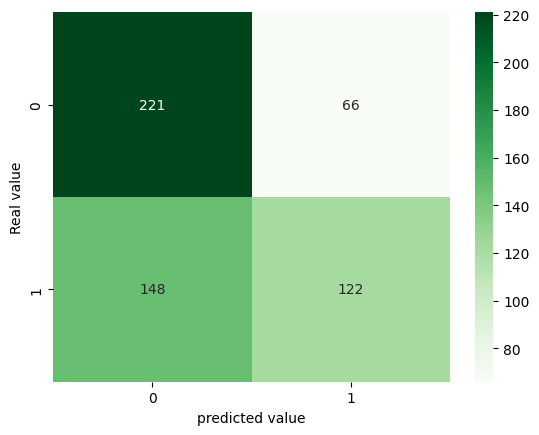

In [9]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Градиентный бустинг

### XGBoost

In [10]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=200)

# Вывод лучших гиперпараметров и результата
# print("Лучшие гиперпараметры:", study.best_params)
# print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train_scaled, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test_scaled)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred, average='weighted'))
# Вывод параметров лучшей модели
print("Параметры лучшей модели:", best_model.get_params())

[I 2025-01-15 09:33:30,480] A new study created in memory with name: no-name-20a23130-e85a-494e-91c5-65d99fee87b8
[I 2025-01-15 09:33:30,626] Trial 0 finished with value: 0.34615384615384615 and parameters: {'max_depth': 10, 'learning_rate': 0.045446246331285696, 'n_estimators': 12, 'gamma': 5.996806618398823, 'subsample': 0.8463073284374787, 'colsample_bytree': 0.7402757126962443, 'reg_alpha': 0.08349326581403907, 'reg_lambda': 0.5485573658689624}. Best is trial 0 with value: 0.34615384615384615.
[I 2025-01-15 09:33:31,187] Trial 1 finished with value: 0.42857142857142855 and parameters: {'max_depth': 13, 'learning_rate': 0.011050566637559104, 'n_estimators': 94, 'gamma': 0.025220318762919712, 'subsample': 0.9676065040965796, 'colsample_bytree': 0.5602908298881295, 'reg_alpha': 3.5129606352515146, 'reg_lambda': 0.06930019004999109}. Best is trial 1 with value: 0.42857142857142855.
[I 2025-01-15 09:33:31,252] Trial 2 finished with value: 0.536 and parameters: {'max_depth': 3, 'learning

F1-мера модели с лучшими гиперпараметрами: 0.6445273345688943
Параметры лучшей модели: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8412894198679532, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 1.9850389773135493, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.19761424786578174, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 95, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 4.196979392367971, 'reg_lambda': 0.0524389657892104, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8031907692254562, 'tr

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.74      0.68       287
           1       0.67      0.55      0.60       270

    accuracy                           0.65       557
   macro avg       0.65      0.65      0.64       557
weighted avg       0.65      0.65      0.64       557



Text(0.5, 23.52222222222222, 'predicted value')

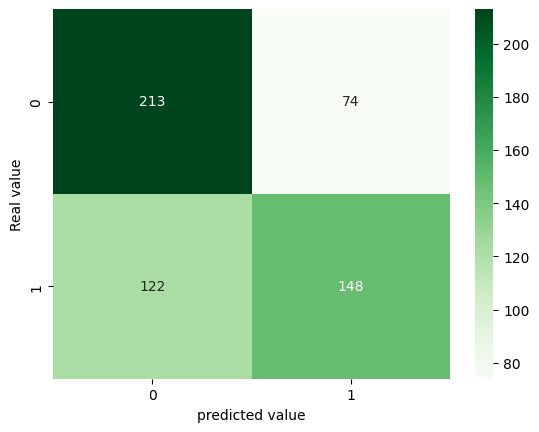

In [11]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### PyTorch

In [58]:
# Стандартизация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    
# Параметры модели
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [59]:
# Обучение модели
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
# Оценка модели
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score: {f1:.4f}')

In [ ]:
# Функция для аугментации данных
def augment_data(X, y, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise
    y_augmented = y.copy()
    return X_augmented, y_augmented

# Аугментация тренировочных данных
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented, dtype=torch.float32)
# y_train_augmented_tensor = torch.tensor(y_train_augmented.values, dtype=torch.long)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after augmentation: {accuracy:.4f}')

    # Вычисление F1-меры
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after augmentation: {f1:.4f}')

Датасет + аугментированный датасет

In [ ]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.001
num_epochs = 100
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader для базовых данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Функция для аугментации данных
def augment_data(X,noise_level=0.03):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise  
    return X_augmented

# Аугментация тренировочных данных
X_train_augmented = augment_data(X_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented, dtype=torch.float32)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели на базовых данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на базовых данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on base data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on base data: {f1:.4f}')

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on augmented data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on augmented data: {f1:.4f}')